In [16]:
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
from datetime import datetime as dt

df = pl.read_csv('../data/jan_data.csv')
# df['time'] = pl.to_datetime(df['time'])
df = df.with_columns(pl.col('time').str.to_datetime())

df[1800]['dollar_open_interest_close']

df.tail(10)[['time','premium']]


,time,product,high_price,coin_open_interest_close,funding_rate,sell_coin_volume,search_resolution,search_end_time,liquidations_dollar_volume,dollar_open_interest_high,total_trades,dollar_open_interest_close,coin_open_interest_low,buy_liquidations,liquidations_coin_volume,buy_trades,dollar_volume,buy_dollar_volume,sell_liquidations,sell_dollar_volume,low_price,buy_coin_volume,coin_open_interest_high,premium,open_price,dollar_open_interest_low,search_start_time,_id,sell_liquidations_dollar_volume,coin_volume,close_price,buy_liquidations_coin_volume,exchange,sell_liquidations_coin_volume,buy_liquidations_dollar_volume,coin,sell_trades,search_params
i64,datetime[μs],str,f64,f64,f64,f64,f64,str,f64,f64,i64,f64,f64,i64,f64,i64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,str,str,f64,f64,f64,f64,str,f64,f64,str,i64,str
0,2024-01-01 00:00:00,"""ETHUSDT""",2284.79,779411.923,0.000279,861.942,1.0,"""2024-01-02T00:…",0.0,1.7808e9,1657,1.7801e9,779411.923,0,0.0,733,3.1181e6,1.1497e6,0,1.9684e6,2282.97,503.407,779678.512,1.73637,2283.85,1.7796e9,"""2024-01-01T00:…","""65afcfb08f0cfa…",0.0,1365.349,2283.89,0.0,"""binance-future…",0.0,0.0,"""ETH""",924,null
1,2024-01-01 00:01:00,"""ETHUSDT""",2285.9,779478.029,0.000279,282.335,1.0,"""2024-01-02T00:…",0.0,1.7817e9,1355,1.7817e9,779411.923,0,0.0,890,2.0658e6,1.4207e6,0,645123.665,2283.85,621.711,779478.029,1.838559,2283.89,1.7801e9,"""2024-01-01T00:…","""65afcfb08f0cfa…",0.0,904.046,2285.68,0.0,"""binance-future…",0.0,0.0,"""ETH""",465,null
2,2024-01-01 00:02:00,"""ETHUSDT""",2286.37,779300.292,0.000278,558.508,1.0,"""2024-01-02T00:…",196.621,1.7822e9,1236,1.7817e9,779300.292,0,0.086,777,3.1119e6,1.8353e6,1,1.2767e6,2285.27,802.824,779478.029,1.782707,2285.68,1.7814e9,"""2024-01-01T00:…","""65afcfb18f0cfa…",196.621,1361.332,2286.3,0.0,"""binance-future…",0.086,0.0,"""ETH""",459,null
3,2024-01-01 00:03:00,"""ETHUSDT""",2288.44,778893.962,0.0002785,458.546,1.0,"""2024-01-02T00:…",0.0,1.7829e9,2447,1.7821e9,778893.962,0,0.0,1771,5.0140e6,3.9652e6,0,1.0489e6,2286.29,1733.365,779300.292,1.876332,2286.3,1.7817e9,"""2024-01-01T00:…","""65afcfb18f0cfa…",0.0,2191.911,2288.35,0.0,"""binance-future…",0.0,0.0,"""ETH""",676,null
4,2024-01-01 00:04:00,"""ETHUSDT""",2289.92,778817.135,0.000278,699.95,1.0,"""2024-01-02T00:…",124503.344,1.7835e9,2095,1.7832e9,778817.135,2,54.381,1533,4.4562e6,2.8536e6,0,1.6026e6,2288.35,1246.462,778945.853,1.90327,2288.35,1.7821e9,"""2024-01-01T00:…","""65afcfb28f0cfa…",0.0,1946.412,2289.92,54.381,"""binance-future…",0.0,124503.344,"""ETH""",562,null
5,2024-01-01 00:05:00,"""ETHUSDT""",2291.93,779251.57,0.000279,1371.595,1.0,"""2024-01-02T00:…",3617.094,1.7859e9,3535,1.7854e9,778817.135,2,1.579,2462,8.4564e6,5.3143e6,0,3.1420e6,2288.77,2320.074,779296.723,1.901409,2289.92,1.7825e9,"""2024-01-01T00:…","""65afcfb28f0cfa…",0.0,3691.669,2291.45,1.579,"""binance-future…",0.0,3617.094,"""ETH""",1073,null
6,2024-01-01 00:06:00,"""ETHUSDT""",2293.22,779371.18,0.000279,839.17,1.0,"""2024-01-02T00:…",91084.195,1.7874e9,2146,1.7866e9,779251.57,2,39.726,1300,4.7938e6,2.8702e6,1,1.9236e6,2291.45,1252.182,779536.625,1.871188,2291.45,1.7854e9,"""2024-01-01T00:…","""65afcfb38f0cfa…",5179.92,2091.352,2292.3,37.466,"""binance-future…",2.26,85904.275,"""ETH""",846,null
7,2024-01-01 00:07:00,"""ETHUSDT""",2294.0,780184.747,0.000279,1424.779,1.0,"""2024-01-02T00:…",0.0,1.7890e9,2451,1.7883e9,779371.18,0,0.0,1281,7.1970e6,3.9306e6,0,3.2664e6,2291.72,1714.433,780184.747,1.795697,2292.3,1.7863e9,"""2024-01-01T00:…","""65afcfb38f0cfa…",0.0,3139.212,2292.26,0.0,"""binance-future…",0.0,0.0,"""ETH""",1170,null
8,2024-01-01 00:08:00,"""ETHUSDT""",2292.55,780241.493,0.00028,808.786,1.0,"""2024-01-02T00:…",0.0,1.7885e9,1147,1.7883e9,780184.747,0,0.0,501,2.6542e6,800843.573,0,1.8533e6,2290.88,349.499,780259.623,1.737097,2292.26,1.7873e9,"""2024-01-01T00:…","""65afcfb48f0cfa…",0.0,1158.285,2292.54,0.0,"""binance-future…",0.0,0.0,"""ETH""",646,null


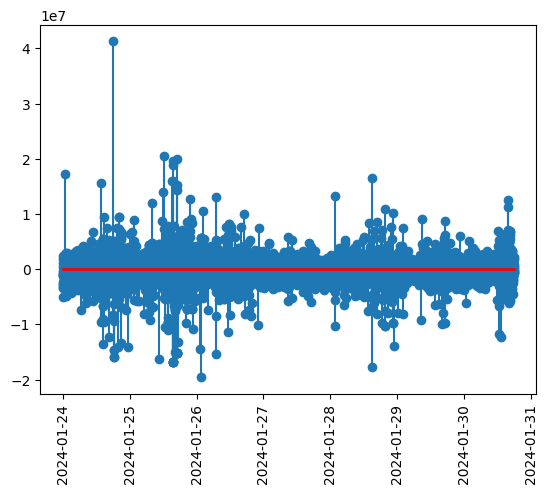

In [27]:

df = df.with_columns(
    diff = df['dollar_open_interest_close'].diff()
)

df_jan2324 = df.filter([pl.col('time')>pl.datetime(2024, 1, 24)])
# df_jan2324 = df
x = df_jan2324['time']
y = df_jan2324['diff']
plt.xticks(rotation=90)
markerline, stemlines, baseline  = plt.stem(x,y)
plt.setp(baseline, color='r', linewidth=2)

plt.show()


In [60]:
from scipy import stats
import math
import numpy as np

df_slice = df_jan2324.filter(pl.col('search_resolution')==1)
df_slice = df_slice.sort('time')
df_slice = df_slice.unique(subset=['time'])

window_size = 240
step = 120
start = 0
end = start + window_size
max_increase_tau = {'tau': 0, 'range_low':0, 'range_high':0, 'oi_difference':0}
max_decrease_tau = {'tau': 0, 'range_low':0, 'range_high':0, 'oi_difference':0}

# calcuate tau, calculate OI increase for those with positive tau, calculate funding and premium avg for the periods
rows = []
while end < len(df_slice):
    df_cut = df_slice[start:end].with_row_index()
    tau_oi = stats.kendalltau(df_cut['index'], df_cut['dollar_open_interest_close'])
    tau_price = stats.kendalltau(df_cut['index'], df_cut['close_price'])
    if tau_oi.statistic < 0:
        if max_decrease_tau['tau'] > tau_oi.statistic:
            max_decrease_tau = {'tau': tau_oi.statistic, 'range_low': start, 'range_high': end}
    else:
        # get mean premium for period
        premium = df_cut['premium'].mean()
        # get mean funding for period
        funding = df_cut['funding_rate'].mean()
        # OI increase
        oi_increase = df_cut[-1]['dollar_open_interest_close']-df_cut[1]['dollar_open_interest_close']
        # print(f"{oi_increase:,f} USD, {tau_oi.statistic}, 'Price Tau:' {tau_price.statistic} 'Avg funding:' {funding}, 'Avg premium:' {premium}, 'date_start': {df_slice.iloc[max_increase_tau['range_low']]['time']}, 'date_end': {df_slice.iloc[max_increase_tau['range_high']]['time']}")
        rows.append({"Start_Date": df_slice[max_increase_tau['range_low']]['time'], "End_Date": df_slice[max_increase_tau['range_high']]['time'], "TAU_OI": tau_oi.statistic, "TAU_Price": tau_price.statistic, "Funding": funding, "Premium": premium})
        max_increase_tau = {'tau': tau_oi.statistic, 'range_low': start, 'range_high': end}
    start += step
    end += step

df = pd.DataFrame(rows)
# identify ranges where price up, oi up + below 0.01 per 8 hr funding or neg premium
df_up = df.loc[(df['TAU_Price']>0.6) & (df['TAU_OI']>0.6) & ((df['Funding']<-0.0001) | (df['Premium']<0))]
# or price down, oi down + above 0.01 per 8hr funding or pos premium
df_down = df.loc[(df['TAU_Price']<-0.7) & (df['TAU_OI']<-0.7) & ((df['Funding']>0.0001) | (df['Premium']>0))]

# df_up
# df_down

,Start_Date,End_Date,TAU_OI,TAU_Price,Funding,Premium


In [61]:
max_increase_tau = {'tau': 0, 'range_low':0, 'range_high':0, 'oi_difference':0}
max_decrease_tau = {'tau': 0, 'range_low':0, 'range_high':0, 'oi_difference':0}
df = pl.DataFrame()

# calcuate tau, calculate OI increase for those with positive tau, calculate funding and premium avg for the periods
while end < len(df_slice):
    df_cut = df_slice[start:end].with_row_index()
    tau = stats.kendalltau(df_cut.index, df_cut['dollar_open_interest_close'])
    if tau.statistic < 0:
        if max_decrease_tau['tau'] > tau.statistic:
            max_decrease_tau = {'tau': tau.statistic, 'range_low': start, 'range_high': end}
    else:
        # get mean premium for period
        premium = df_cut['premium'].mean()
        # get mean funding for period
        funding = df_cut['funding_rate'].mean()
        # OI increase
        oi_increase = df_cut[-1]['dollar_open_interest_close']-df_cut[1]['dollar_open_interest_close']
        print(f"{oi_increase:,f} USD, {tau.statistic}, 'Avg funding:' {funding}, 'Avg premium:' {premium}, 'date_start': {df_slice[max_increase_tau['range_low']]['time']}, 'date_end': {df_slice[max_increase_tau['range_high']]['time']}")
        max_increase_tau = {'tau': tau.statistic, 'range_low': start, 'range_high': end}
    # print(f"Range: {start} to {end}: {stats.kendalltau(df_cut.index, df_cut['dollar_open_interest_close'])}")
    start += step
    end += step


In [96]:
from scipy import stats
import math

df_slice = df_jan2324.filter(pl.col('search_resolution')==1)
df_slice = df_slice.sort('time')
df_slice = df_slice.unique(subset=['time'])

window_size = 60*4
return_step =48*60
step = 60
start = 0
end = start + window_size

final_df = pl.DataFrame()
rows = []
# need to redo this part since slicing is more efficient
while end < len(df_slice):
    df_cut = df_slice[start:end].with_row_index()
    df_return = df_slice[end:(end+return_step)]

    # get tau stat oi
    tau_oi = stats.kendalltau(df_cut['index'], df_cut['dollar_open_interest_close'])
    
    # get tau stat price
    tau_price = stats.kendalltau(df_cut['index'], df_cut['close_price'])

    # get mean premium for period
    premium = df_cut['premium'].mean()
    # get mean funding for period
    funding = df_cut['funding_rate'].mean()
    # OI increase
    oi_increase = df_cut[-1]['dollar_open_interest_close']/df_cut[0]['dollar_open_interest_close']-1
    # Long Liquidations
    long_liq = df_cut['buy_liquidations_coin_volume'].mean()#df_cut.iloc['buy_liquidations_coin_volume'].sum()
    # Short Liquidations
    short_liq = df_cut['sell_liquidations_coin_volume'].mean()#df_cut.iloc['short_liquidations_coin_volume'].sum()
    
    # Open Price
    open_price = df_return[0]['open_price']

    # 4hr Price
    close_price_4hr = df_return[0:(4*60)][-1]['close_price']
    # 4hr Price change
    price_change_4hr = close_price_4hr/open_price-1
    
    # 12hr Price
    close_price_12hr = df_return[0:(12*60)][-1]['close_price']
    # 12hr Price change
    price_change_12hr = close_price_12hr/open_price-1

    # 24hr Price
    close_price_24hr = df_return[0:(24*60)][-1]['close_price']
    # 24hr Price change
    price_change_24hr = close_price_24hr/open_price-1

    # 48hr Price
    close_price_48hr = df_return[0:(48*60)][-1]['close_price']
    # 48hr Price change
    price_change_48hr = close_price_48hr/open_price-1

    print(df_cut.select(pl.first('time'))
    # Create Row
    row = rows.append({df_cut.select(pl.first('time')), df_cut.select(pl.last('time')) , oi_increase ,long_liq, short_liq, tau_oi.statistic , tau_price.statistic, funding , premium , price_change_4hr , price_change_12hr , price_change_24hr , price_change_48hr})
    #print(row)
    
    start += step
    end += step

# df = df.reset_index(drop=True)
df

TypeError: unhashable type: 'Series'